In [ ]:
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd
import geopandas as gpd
import xarray as xr

from glob import glob
from tqdm import tqdm
from pathlib import Path
from datetime import timedelta
from shapely import wkt
from shapely.geometry import Point, LineString

datasets = Path("/nas/cee-water/cjgleason/data")
era5_dir = datasets / "ERA5-Land/sub_basin_timeseries"

save_dir = Path("/nas/cee-water/cjgleason/ted/swot-ml/data/reservoirs")
metadata_dir = save_dir / "metadata"
sites_dir = metadata_dir / "site_lists"
sites_dir.mkdir(exist_ok=True)

fig_dir = save_dir / '_figures' / 'train_test'
fig_dir.mkdir(exist_ok=True)

basin = 'Ohio'
# basin = 'Upper_Miss'
# basin = 'Missouri'

matchups = gpd.read_file(
    metadata_dir / f"{basin}_matchups.gpkg",
    layer="matchups"
).set_index('comid')
matchups.index = matchups.index.astype(str)

all_sites = matchups[matchups['custom'] & (matchups.index != 'outlet')]

In [17]:
all_sites

,outlet,total_area,unitarea,reservoir,custom,reach_id,sword_area,sword_distance,lake_reach_ids,lake_pld_ids,...,nli_ix_sav,rdd_mk_sav,hft_ix_s93,hft_ix_s09,gad_id_smj,gdp_ud_sav,gdp_ud_ssu,hdi_ix_sav,hybas_area_diff,geometry
comid,,,,,,,,,,,,,,,,,,,,,
USGS-03007800,POINT (-78.2925 41.8183),652.0,652.0,False,True,NaN,NaN,NaN,[],[],...,996,251,88,98,240,57796,6.101747e+07,947,-0.015612,"MULTIPOLYGON (((-78.32042 41.81708, -78.32042 ..."
USGS-03010500,POINT (-78.3867 41.9633),1537.0,885.2,False,True,NaN,NaN,NaN,[],[],...,957,579,105,111,240,58334,3.125212e+07,948,0.023151,"MULTIPOLYGON (((-78.41542 41.63042, -78.41542 ..."
USGS-03010820,POINT (-78.4508 42.0725),3023.0,761.0,False,True,7.426990e+10,3618.283133,0.0,[],[],...,2341,614,142,162,240,63747,9.479501e+08,952,0.054291,"MULTIPOLYGON (((-78.48042 42.26458, -78.48792 ..."
USGS-03011020,POINT (-78.715 42.1567),4163.5,425.1,False,True,7.426990e+10,4018.413586,0.0,[],[],...,3949,870,301,321,240,63747,2.879590e+08,952,0.001560,"MULTIPOLYGON (((-78.70125 42.13292, -78.70208 ..."
USGS-03012550,POINT (-79.0117 41.8425),5591.6,754.3,True,True,7.426990e+10,4926.857910,0.0,"[74269900463, 74269900363, 74269900373, 742699...",[7421097453],...,1838,422,140,154,240,53263,4.273464e+08,943,0.019112,"MULTIPOLYGON (((-78.98542 41.81875, -78.98875 ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
USGS-03601600,POINT (-87.2658 35.72),4488.2,983.3,False,True,7.426220e+10,4155.014445,0.0,[],[],...,537,208,72,82,240,45808,5.052637e+07,810,0.001625,"MULTIPOLYGON (((-87.31792 35.66792, -87.31792 ..."
USGS-03601990,POINT (-87.46 35.7842),5415.0,926.8,False,True,7.426220e+10,4583.058778,0.0,[],[],...,1460,185,157,129,240,45808,2.195454e+08,810,-0.003237,"MULTIPOLYGON (((-87.47708 35.52208, -87.47958 ..."
USGS-03603000,POINT (-87.7425 35.93),6784.7,372.2,False,True,7.426220e+10,5400.929199,0.0,[],[],...,307,172,55,56,240,45808,1.265268e+06,810,0.012538,"MULTIPOLYGON (((-87.74375 35.92292, -87.74375 ..."


In [18]:
def write_index_sites(df, stem):
    sites = list(df.index.astype(str))
    with open(metadata_dir/'site_lists'/f'{stem}.txt', "w") as file:
        file.write("\n".join(sites) + "\n")

write_index_sites(all_sites, f'{basin}_all')

In [35]:
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

def plot_train_test(_train, _test):
    _train['subset'] = 'train'
    _test['subset'] = 'test'
    all_basin = pd.concat([_train, _test])

    colors = ['tab:blue', 'tab:orange']
    cmap = ListedColormap(colors)

    
    plt.close('all')
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    all_basin.plot(column='subset', categories=['train','test'], legend=True, ax=axes[0], cmap=cmap)
    # Move legend to top left
    legend = axes[0].get_legend()
    legend.set_bbox_to_anchor((1, 1)) 

    bin_range = (
        np.floor(np.log10(all_basin['total_area'].min())),
        np.ceil(np.log10(all_basin['total_area'].max()))
    )
    # bmax = np.ceil(np.log10(train_df['hybas_area'].max()))
    # bmax = np.ceil(np.log10(train_df['hybas_area'].max()))
    
    axes[1].hist(np.log10(_train['total_area']), bins=10, range=bin_range)
    axes[1].hist(np.log10(_test['total_area']), alpha=0.7, bins=10, range=bin_range)
    axes[1].set_xlabel('Log10 Upstream Area (km)')

    plt.suptitle(f'{basin} watershed train / test')
    fig.tight_layout()
    
    
    return fig, axes

In [21]:
all_sites

,outlet,total_area,unitarea,reservoir,custom,reach_id,sword_area,sword_distance,lake_reach_ids,lake_pld_ids,...,nli_ix_sav,rdd_mk_sav,hft_ix_s93,hft_ix_s09,gad_id_smj,gdp_ud_sav,gdp_ud_ssu,hdi_ix_sav,hybas_area_diff,geometry
comid,,,,,,,,,,,,,,,,,,,,,
USGS-03007800,POINT (-78.2925 41.8183),652.0,652.0,False,True,NaN,NaN,NaN,[],[],...,996,251,88,98,240,57796,6.101747e+07,947,-0.015612,"MULTIPOLYGON (((-78.32042 41.81708, -78.32042 ..."
USGS-03010500,POINT (-78.3867 41.9633),1537.0,885.2,False,True,NaN,NaN,NaN,[],[],...,957,579,105,111,240,58334,3.125212e+07,948,0.023151,"MULTIPOLYGON (((-78.41542 41.63042, -78.41542 ..."
USGS-03010820,POINT (-78.4508 42.0725),3023.0,761.0,False,True,7.426990e+10,3618.283133,0.0,[],[],...,2341,614,142,162,240,63747,9.479501e+08,952,0.054291,"MULTIPOLYGON (((-78.48042 42.26458, -78.48792 ..."
USGS-03011020,POINT (-78.715 42.1567),4163.5,425.1,False,True,7.426990e+10,4018.413586,0.0,[],[],...,3949,870,301,321,240,63747,2.879590e+08,952,0.001560,"MULTIPOLYGON (((-78.70125 42.13292, -78.70208 ..."
USGS-03012550,POINT (-79.0117 41.8425),5591.6,754.3,True,True,7.426990e+10,4926.857910,0.0,"[74269900463, 74269900363, 74269900373, 742699...",[7421097453],...,1838,422,140,154,240,53263,4.273464e+08,943,0.019112,"MULTIPOLYGON (((-78.98542 41.81875, -78.98875 ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
USGS-03601600,POINT (-87.2658 35.72),4488.2,983.3,False,True,7.426220e+10,4155.014445,0.0,[],[],...,537,208,72,82,240,45808,5.052637e+07,810,0.001625,"MULTIPOLYGON (((-87.31792 35.66792, -87.31792 ..."
USGS-03601990,POINT (-87.46 35.7842),5415.0,926.8,False,True,7.426220e+10,4583.058778,0.0,[],[],...,1460,185,157,129,240,45808,2.195454e+08,810,-0.003237,"MULTIPOLYGON (((-87.47708 35.52208, -87.47958 ..."
USGS-03603000,POINT (-87.7425 35.93),6784.7,372.2,False,True,7.426220e+10,5400.929199,0.0,[],[],...,307,172,55,56,240,45808,1.265268e+06,810,0.012538,"MULTIPOLYGON (((-87.74375 35.92292, -87.74375 ..."


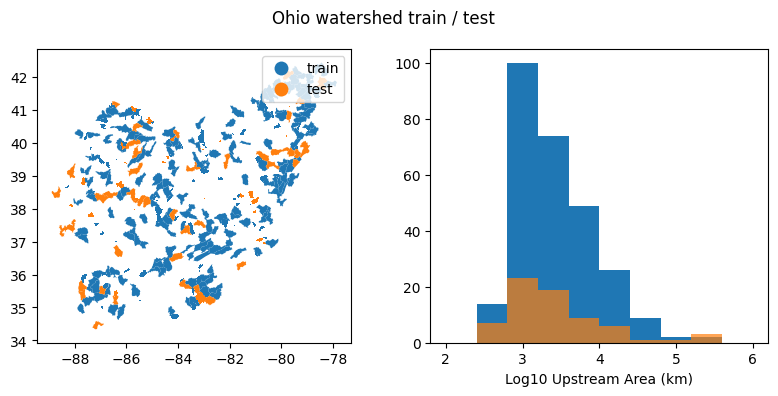

In [36]:
train_df = all_sites.sample(frac=0.8, random_state=42)
test_df = all_sites.drop(train_df.index)

fig, axes = plot_train_test(train_df, test_df)
fig.savefig(fig_dir / f'random_split_{basin}.png', dpi=300)

write_index_sites(train_df, f'{basin}_random_train')
write_index_sites(test_df, f'{basin}_random_test')

In [37]:
sword_sites

,outlet,total_area,unitarea,reservoir,custom,reach_id,sword_area,sword_distance,lake_reach_ids,lake_pld_ids,...,rdd_mk_sav,hft_ix_s93,hft_ix_s09,gad_id_smj,gdp_ud_sav,gdp_ud_ssu,hdi_ix_sav,hybas_area_diff,geometry,subset
comid,,,,,,,,,,,,,,,,,,,,,
USGS-03010820,POINT (-78.4508 42.0725),3023.0,761.0,False,True,7.426990e+10,3618.283133,0.0,[],[],...,614,142,162,240,63747,9.479501e+08,952,0.054291,"MULTIPOLYGON (((-78.48042 42.26458, -78.48792 ...",train
USGS-03011020,POINT (-78.715 42.1567),4163.5,425.1,False,True,7.426990e+10,4018.413586,0.0,[],[],...,870,301,321,240,63747,2.879590e+08,952,0.001560,"MULTIPOLYGON (((-78.70125 42.13292, -78.70208 ...",train
USGS-03012550,POINT (-79.0117 41.8425),5591.6,754.3,True,True,7.426990e+10,4926.857910,0.0,"[74269900463, 74269900363, 74269900373, 742699...",[7421097453],...,422,140,154,240,53263,4.273464e+08,943,0.019112,"MULTIPOLYGON (((-78.98542 41.81875, -78.98875 ...",train
USGS-03015310,POINT (-79.1492 41.8433),8334.2,0.3,False,True,7.426990e+10,8675.438017,0.0,[],[],...,510,242,266,240,53263,2.454829e+08,943,-0.023380,"MULTIPOLYGON (((-79.14708 41.84625, -79.14708 ...",train
USGS-03016000,POINT (-79.4058 41.5708),9714.7,439.3,False,True,7.426990e+10,9554.466292,0.0,[],[],...,194,81,84,240,53263,7.743318e+07,943,-0.013482,"MULTIPOLYGON (((-79.39708 41.57208, -79.39708 ...",train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
USGS-03601600,POINT (-87.2658 35.72),4488.2,983.3,False,True,7.426220e+10,4155.014445,0.0,[],[],...,208,72,82,240,45808,5.052637e+07,810,0.001625,"MULTIPOLYGON (((-87.31792 35.66792, -87.31792 ...",train
USGS-03601990,POINT (-87.46 35.7842),5415.0,926.8,False,True,7.426220e+10,4583.058778,0.0,[],[],...,185,157,129,240,45808,2.195454e+08,810,-0.003237,"MULTIPOLYGON (((-87.47708 35.52208, -87.47958 ...",train
USGS-03603000,POINT (-87.7425 35.93),6784.7,372.2,False,True,7.426220e+10,5400.929199,0.0,[],[],...,172,55,56,240,45808,1.265268e+06,810,0.012538,"MULTIPOLYGON (((-87.74375 35.92292, -87.74375 ...",train


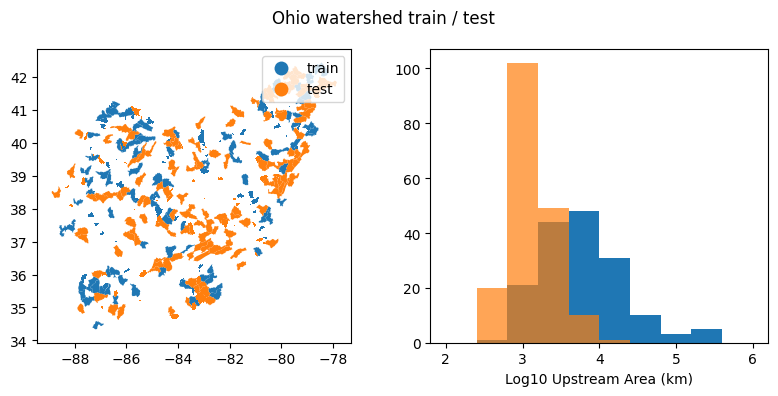

In [38]:
has_sword = ~all_sites['reach_id'].isna()
sword_sites = all_sites[has_sword].copy()
other_sites = all_sites[~has_sword].copy()

fig, axes = plot_train_test(sword_sites, other_sites)
fig.savefig(fig_dir / f'swot_split_{basin}.png', dpi=300)

write_index_sites(sword_sites, f'{basin}_Sword')
write_index_sites(other_sites, f'{basin}_noSword')